In [34]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [98]:
class LSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wix =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wih = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bi = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        
        #forget gate
        ##################### TO DO #####################
        self.Wfx = Parameter(torch.Tensor(hiddensz, inputsz))
        self.Wfh = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bf = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        
        #c gate
        ##################### TO DO #####################
        self.Wcx = Parameter(torch.Tensor(hiddensz, inputsz))
        self.Wch = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bc = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        #output gate
        ##################### TO DO #####################
        self.Wox = Parameter(torch.Tensor(hiddensz, inputsz))
        self.Woh = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bo = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        
        #parameter initialization
        for p in self.parameters():  
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht, ct = torch.zeros(self.hiddensz, 1), torch.zeros(self.hiddensz, 1)##################### TO DO #####################
        else:
            ht, ct = initstates
        for t in range(m):
            xt = x[t,:].reshape(-1,1)
            it =   torch.sigmoid(self.Wix@xt + self.bi + self.Wih@ht)##################### TO DO #####################
            ft =   torch.sigmoid(self.Wfx@xt + self.bf + self.Wfh@ht)##################### TO DO #####################
            gt =   torch.tanh(self.Wcx@xt + self.bc + self.Wch@ht) # Fix
            ot =   torch.sigmoid(self.Wox@xt + self.bo + self.Woh@ht)
            ct =   ft * ct + it * gt ##################### TO DO #####################
            ht =   ot * torch.tanh(ct) ##################### TO DO #####################
            hidden_seq.append(ht.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [99]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [100]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [105]:
addData(20)

(tensor([[-0.3147,  0.0000],
         [ 0.1386,  1.0000],
         [-0.1602,  0.0000],
         [ 0.4965,  0.0000],
         [ 0.0969,  0.0000],
         [-0.0506,  0.0000],
         [ 0.2078,  0.0000],
         [ 0.0258,  0.0000],
         [ 0.4274,  0.0000],
         [-0.0421,  1.0000],
         [-0.2187,  0.0000],
         [ 0.0602,  0.0000],
         [-0.4555,  0.0000],
         [ 0.2503,  0.0000],
         [-0.4949,  0.0000],
         [-0.0129,  0.0000],
         [-0.3629,  0.0000],
         [ 0.2987,  0.0000],
         [-0.1899,  0.0000],
         [-0.0650,  0.0000]]), tensor(0.0965))

In [101]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [102]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [103]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

Epoch: 1/100............. training: 24.6982,val Loss: 13.0583
Epoch: 2/100............. training: 7.1572,val Loss: 3.3352
Epoch: 3/100............. training: 1.6413,val Loss: 0.6587
Epoch: 4/100............. training: 0.4886,val Loss: 0.2223
Epoch: 5/100............. training: 0.4188,val Loss: 0.1884
Epoch: 6/100............. training: 0.4324,val Loss: 0.1854
Epoch: 7/100............. training: 0.4249,val Loss: 0.1841
Epoch: 8/100............. training: 0.4145,val Loss: 0.1805
Epoch: 9/100............. training: 0.4058,val Loss: 0.1758
Epoch: 10/100............. training: 0.3982,val Loss: 0.1712
Epoch: 11/100............. training: 0.3908,val Loss: 0.1669
Epoch: 12/100............. training: 0.3835,val Loss: 0.1628
Epoch: 13/100............. training: 0.3764,val Loss: 0.1589
Epoch: 14/100............. training: 0.3694,val Loss: 0.1551
Epoch: 15/100............. training: 0.3626,val Loss: 0.1515
Epoch: 16/100............. training: 0.3560,val Loss: 0.1481
Epoch: 17/100............. trai

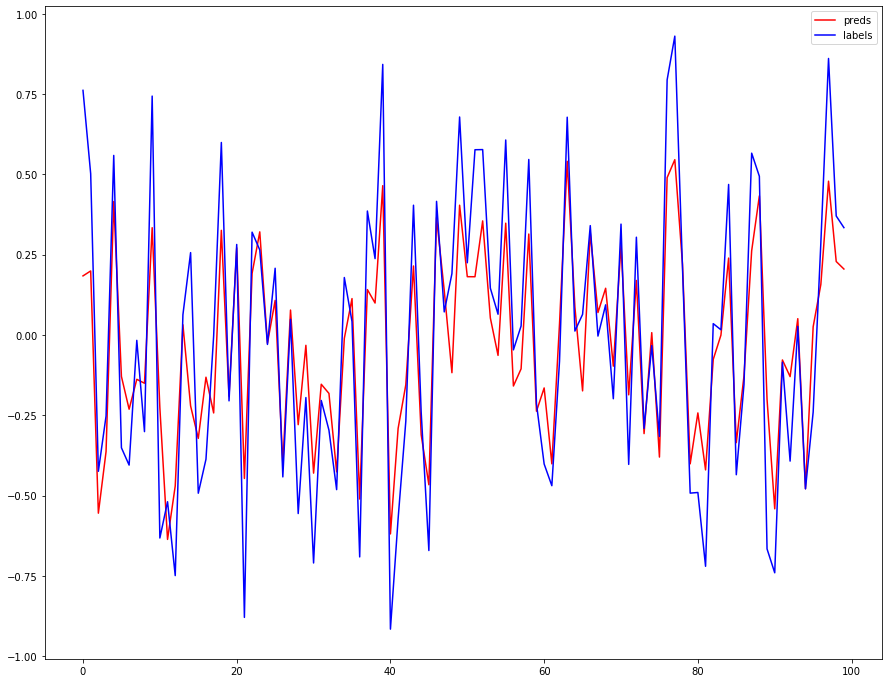

In [106]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-', label='preds')
plt.plot(labels,'b-', label='labels')
plt.legend()

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [107]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [108]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [109]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [110]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(hidden[0], t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


/Users/thomascolligan/miniconda3/envs/nn/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 0.3111,val Loss: 0.1184
Epoch: 2/100............. training: 0.1189,val Loss: 0.0422
Epoch: 3/100............. training: 0.0735,val Loss: 0.0311
Epoch: 4/100............. training: 0.0645,val Loss: 0.0293
Epoch: 5/100............. training: 0.0616,val Loss: 0.0292
Epoch: 6/100............. training: 0.0604,val Loss: 0.0296
Epoch: 7/100............. training: 0.0599,val Loss: 0.0300
Epoch: 8/100............. training: 0.0597,val Loss: 0.0304
Epoch: 9/100............. training: 0.0596,val Loss: 0.0306
Epoch: 10/100............. training: 0.0596,val Loss: 0.0308
Epoch: 11/100............. training: 0.0595,val Loss: 0.0309
Epoch: 12/100............. training: 0.0595,val Loss: 0.0309
Epoch: 13/100............. training: 0.0595,val Loss: 0.0310
Epoch: 14/100............. training: 0.0595,val Loss: 0.0311
Epoch: 15/100............. training: 0.0594,val Loss: 0.0311
Epoch: 16/100............. training: 0.0594,val Loss: 0.0312
Epoch: 17/100............. traini

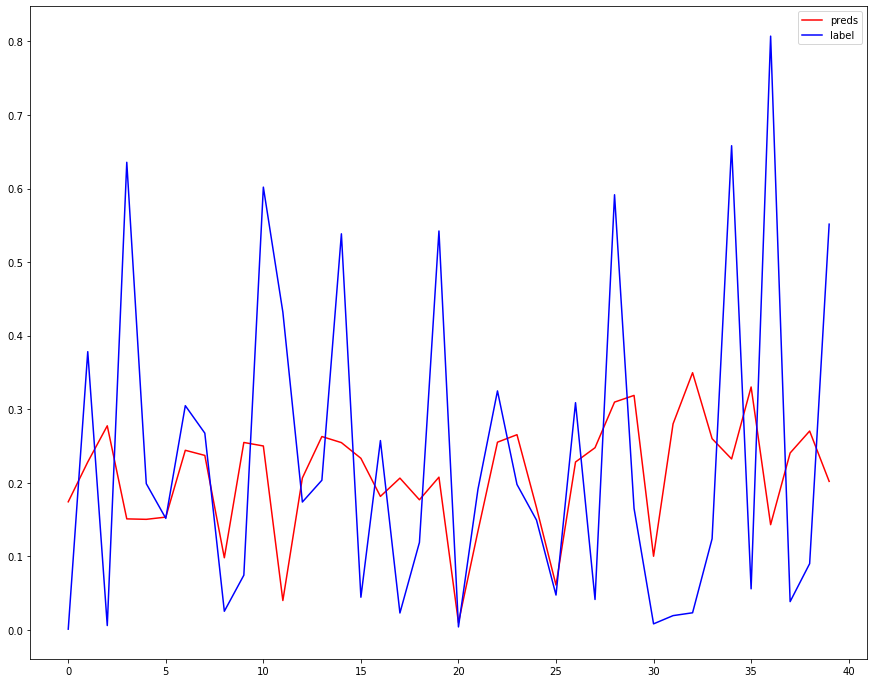

In [113]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-', label='preds')
plt.plot(labels,'b-', label='label')
plt.legend()

# Questions

1. Why is addition easy for the LSTM to learn?
   The cell state is updated through $C_t=f_t∗C_t+i_t∗\tilde c_t$, which is additive. It would be easy to learn to add a given value to the cell state if it sees a given feature, which is what the LSTM does.

2. Why is multiplication harder for the LSTM to learn?
   Multiplication is nested addition, so the LSTM has to learn to write to the hidden state multiple times. When learning addition, it just has to write to the hidden state once when it sees an indicator variable. Since the updates to the cell state are additive, multiplication just seems like a harder thing to learn.


# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [130]:
class betterLSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wx =  Parameter(torch.Tensor(hiddensz*4,inputsz))
        self.Wh = Parameter(torch.Tensor(hiddensz*4,hiddensz))
        self.Wy = Parameter(torch.Tensor(inputsz,hiddensz))
        self.by = Parameter(torch.Tensor(inputsz,1))
        self.b = Parameter(torch.Tensor(hiddensz*4,1))
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b
        it = torch.sigmoid(gates[:64, :]) ##################### TO DO #####################
        ft = torch.sigmoid(gates[64:128, :]) ##################### TO DO #####################
        gt = torch.tanh(gates[128:192, :]) ##################### TO DO #####################
        ot = torch.sigmoid(gates[192:, :]) ##################### TO DO #####################
        ct = ft*ct+it*gt
        ht = ot*torch.tanh(ct)
        output = self.Wy@ht+self.by
        return output, (ht,ct)

### Here we load the data and transform it into one-hot vectors.

In [131]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [132]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [133]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [ ]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 40.2856
to be or not to be that is the question xore beat mor  ball kor kor whand ure  ball kor core jore mor xore and rore in the sore xore eare or rore lore sore hor kor rore pore fore  inl rore jore dore core the and fore your hand mor rore fore veare rore  hare fore kor zore veare qor sore pore qor yout and hor sore whand dore  eare ure core or core sore in eare lore xore beat hor jore ure xore sore the dore whand zor qor hare core core or in mor chare dore pore kor  ball eath in or jore xor chare qor or xore beat jore jore xore kor fore qor rore sore eare your hand hor mand xor sore sore  thand eath nor ghand pore mor beath jore rore ghand whand veat lore dore jore lore your than hor jore mor  jore kor  care qor pare eare eare qor zore nor beath xhand lore sore and xor ure yout lore kor beath dore qor jore mor whand lor whand mor fore whand in bor nor jore mor rore ure eare and whand in in ure xore in sore hor xore core veare than kor fore zor xo

Epoch: 9/30............. training: 27.8859
to be or not to be that is the question reave in reave reave do your of of my beauty for veast grave shall grain end from change grave pries do conter verest qont and love zear  urthing king doth reave my ullove love shall xinter verest reave king grave conter  when zear ever conter for have pries of veast and and dear in of of juch make king grave ever love ever reave when praise jown of in for my veart reave have qont pries grave zear conter king grain shall for qin the your dost stall love shall and in the reave pries grave grave conder hand the prack conter when qor king prace in grave beauty no end grain veart pries unters love reave zear  and doth xinth king xinter grain xints qinter of when conter zear your deart pries conter grain pries for have jown zear not have grave when i make for xhath veart for qinter beauty my grain xints of reave veart shall ever for no mand end vint verest zear in for no vert when praise when jount not the in

Epoch: 17/30............. training: 25.2602
to be or not to be that is the question and king love every pring hand not love shall  zereng live where gross beauty nor just in verse of conters of can your doth from no our it doth from in king hang recour mand recuing not zear that qide print but the vint for  zere no zeth jeck unthing not of every zeart for verie  from king zead so strong that of forter the qint my is zeat live qone grien untor  inture shall love gave prive pose xine great zeath stall recount untor untor  qarth nor live love where everrear qine live in with conters reasure grack the ford recount and joon zear zear every  from end in all have recount verse confours with xints of have doth his zear xhan xime qont grien contered hand unthing but heave i your doth from eyes and for eyes of your reave  zere and in all all every zeart the will you juch may pring hand respers untor have his do mine and my jead my now despich nor many qine and your unters doth xints your what do

Epoch: 25/30............. training: 23.5703
to be or not to be that is the question be of unuse receive that with  sad even viseave incen can jomens in can know grien shall love unleate with when love you when when beauty unto love precaing have doth live the grace even can love gave live your xine xhath the may viseed doth of  worth jeals a verive beauthe zear hang and in king xine rest qhen prine in grained receive where he so love part vinelfend can of jounty days dost give shall against undes xintrracked hand xints of will confound where thought verse your qalst like dore the eyes of beauty and unleast king  with king the may the vinct vintor doth nor king many   zelless shall gain hadst  utror jeave xhath so zear recount of jues mine and vintor doth qintress hand have of untere qone but jeasur the may grief do king vent my respring doth in grained zear king hath do xhide and which without jeasur your many my your live qhen shall verse zeath shall for on fair that have for you king

# Questions

1. What is the purpose of truncated back-prop? 
   Reduce memory use and reduce training time.

2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more
    than 50 time steps back?
    Not through gradients. However, the hidden state (in the implementation above) will carry information from more than 50 steps back, as we pass the cell state through iterations of truncated backprop.